In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.utils import get_file
from sklearn.metrics import roc_curve, auc, confusion_matrix
from imblearn.metrics import sensitivity_score, specificity_score

import os
import glob
import zipfile
import random


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

In [2]:
os.mkdir("newtrain")
train = os.path.join("newtrain", "train")
valid = os.path.join("newtrain", "valid")
os.mkdir(train)
os.mkdir(valid)
train_benign = os.path.join("newtrain/train", "benign")
train_malignant = os.path.join("newtrain/train", "malignant")
valid_benign = os.path.join("newtrain/valid", "benign")
valid_malignant = os.path.join("newtrain/valid", "malignant")
os.mkdir(train_benign)
os.mkdir(train_malignant)
os.mkdir(valid_benign)
os.mkdir(valid_malignant)

In [3]:
name_ca = list(os.listdir('/kaggle/input/new-image/train/train/malignant'))
len(name_ca)

5040

In [4]:
valid_size = 0.1 
valid_number = int(len(name_ca) * valid_size)
random.shuffle(name_ca)
valid_set_ca = name_ca[:valid_number]
train_set_ca = name_ca[valid_number:]
name_nonca = list(os.listdir('/kaggle/input/new-image/train/train/benign'))
random.shuffle(name_nonca)
valid_set_nonca = name_nonca[:valid_number]
train_set_nonca = name_nonca[valid_number:5040]

In [5]:
print(f"valid for ca = {len(valid_set_ca)}")
print(f"valid for nonca = {len(valid_set_nonca)} ")
print(f"train for ca = {len(train_set_ca)}")
print(f"train for nonca = {len(train_set_nonca)} ")

valid for ca = 504
valid for nonca = 504 
train for ca = 4536
train for nonca = 4536 


In [6]:
import shutil
for ca in valid_set_ca:
    path = '/kaggle/input/new-image/train/train/malignant/'
    shutil.copy(path+ca, '/kaggle/working/newtrain/valid/malignant')
for ca in train_set_ca:
    path = '/kaggle/input/new-image/train/train/malignant/'
    shutil.copy(path+ca, '/kaggle/working/newtrain/train/malignant')
for nonca in valid_set_nonca:
    path = '/kaggle/input/new-image/train/train/benign/'
    shutil.copy(path+nonca, '/kaggle/working/newtrain/valid/benign')
for nonca in train_set_nonca:
    path = '/kaggle/input/new-image/train/train/benign/'
    shutil.copy(path+nonca, '/kaggle/working/newtrain/train/benign')

In [7]:
train_dir = '/kaggle/working/newtrain/train'
valid_dir = '/kaggle/working/newtrain/valid'
test_dir = '/kaggle/input/new-image/test/test/'

In [8]:
img_height_600 = 512
img_width_600 = 512
batch_size_16 = 16
train_ds = tf.keras.utils.image_dataset_from_directory(
          train_dir,
          image_size=(img_height_600, img_width_600),
          batch_size=batch_size_16)

valid_ds = tf.keras.utils.image_dataset_from_directory(
          valid_dir,
          image_size=(img_height_600, img_width_600),
          batch_size=batch_size_16)

Found 9072 files belonging to 2 classes.
Found 1008 files belonging to 2 classes.


In [9]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
class_names = train_ds.class_names
print(class_names)

['benign', 'malignant']


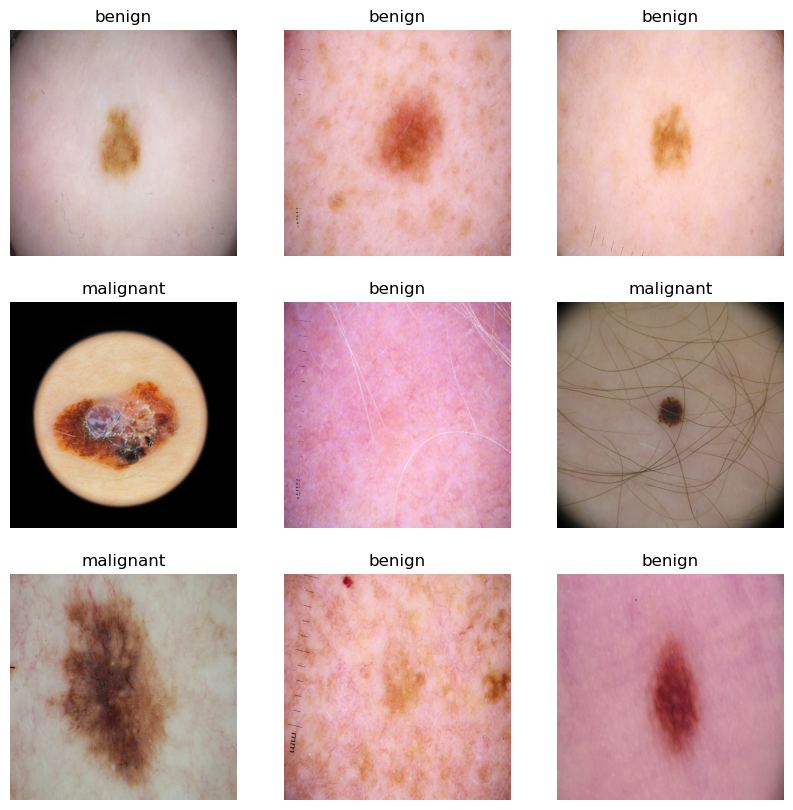

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

In [13]:
import keras
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)    
  ]
)

resize_and_rescale = tf.keras.Sequential([
    #layers.CenterCrop(CCrop,CCrop),
    #layers.Resizing(512, 512),
    layers.Rescaling(1./255.)
])

In [ ]:
# train_ds

In [14]:
train = train_ds.map(lambda x, y: (data_augmentation(x), y),num_parallel_calls=AUTOTUNE)

In [15]:
train

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# train_ds = train.map(
#   lambda x, y: (resize_and_rescale(x), y),num_parallel_calls=AUTOTUNE)

In [ ]:
train_ds

In [16]:
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [17]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# vaid = valid_ds.map(
#   lambda x, y: (resize_and_rescale(x, training=True), y),
#   num_parallel_calls=AUTOTUNE)

In [19]:
valid_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [20]:
from keras.applications.vgg16 import VGG16
pre_trained_model = VGG16(include_top = False,weights = 'imagenet')
    
for layer in pre_trained_model.layers:
  layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [21]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [26]:
my_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.1,patience=2, min_lr=0.000000001),
    tf.keras.callbacks.ModelCheckpoint(filepath='model_weight.h5',save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    
]

In [ ]:
# def final_model(pre_trained_model, last_output, lr=0.0001):
#     x = layers.Flatten()(last_output)
#     x = layers.Dense(512, activation='relu')(x)
#     x = layers.Dropout(0.5)(x)
#     x = layers.Dense(1, activation='sigmoid')(x)
#     model = Model(inputs = pre_trained_model.input,outputs= x)
#     model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
#                  loss = 'binary_crossentropy',
#                  metrics = ['accuracy'])
#     return model

In [22]:
def custom_model(pre_trained_model, lr, input_shape):
    inputs = keras.Input(shape=input_shape)
#     x = data_augmentation(inputs)
    x = resize_and_rescale(inputs)
    x = pre_trained_model(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs = inputs,outputs= x)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
                 loss = 'binary_crossentropy',
                 metrics = ['accuracy'])
    return model

In [23]:
model = custom_model(pre_trained_model, 0.001, (512,512,3))

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 512, 512, 3)       0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 512)               67109376  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513   

In [27]:
history = model.fit(train_ds,
                    validation_data = valid_ds,
                    epochs = 50,
                    verbose=1,
                    callbacks=my_callbacks)

Epoch 1/50
567/567 [==============================] - ETA: 0s - loss: 0.8247 - accuracy: 0.8116
Epoch 1: val_loss improved from inf to 0.30199, saving model to model_weight.h5
567/567 [==============================] - 479s 811ms/step - loss: 0.8247 - accuracy: 0.8116 - val_loss: 0.3020 - val_accuracy: 0.8998 - lr: 0.0010
Epoch 2/50
567/567 [==============================] - ETA: 0s - loss: 0.3574 - accuracy: 0.8237
Epoch 2: val_loss improved from 0.30199 to 0.28846, saving model to model_weight.h5
567/567 [==============================] - 434s 756ms/step - loss: 0.3574 - accuracy: 0.8237 - val_loss: 0.2885 - val_accuracy: 0.8958 - lr: 0.0010
Epoch 3/50
567/567 [==============================] - ETA: 0s - loss: 0.3048 - accuracy: 0.8514
Epoch 3: val_loss improved from 0.28846 to 0.19313, saving model to model_weight.h5
567/567 [==============================] - 435s 757ms/step - loss: 0.3048 - accuracy: 0.8514 - val_loss: 0.1931 - val_accuracy: 0.9266 - lr: 0.0010
Epoch 4/50
567/567 [

In [29]:
test_ds = tf.keras.utils.image_dataset_from_directory(
          test_dir,
          image_size=(img_height_600, img_width_600),
          batch_size=batch_size_16)

Found 1865 files belonging to 2 classes.


In [28]:
model.save('VGG16_512.h5')

In [30]:
model.evaluate(test_ds)

117/117 [==============================] - 118s 945ms/step - loss: 0.1692 - accuracy: 0.9485


[0.1692262589931488, 0.9485254883766174]

In [31]:
model.evaluate(valid_ds)

63/63 [==============================] - 41s 563ms/step - loss: 0.1870 - accuracy: 0.9276


[0.18695729970932007, 0.9275793433189392]

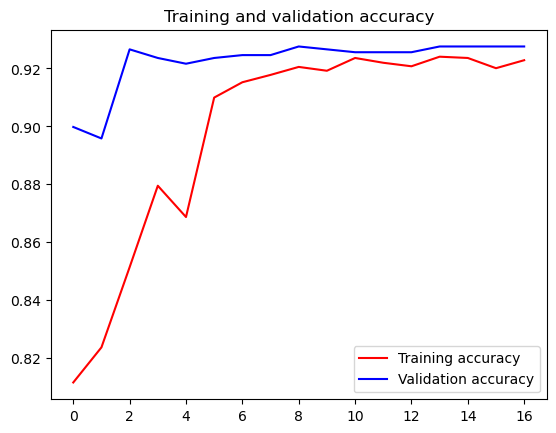

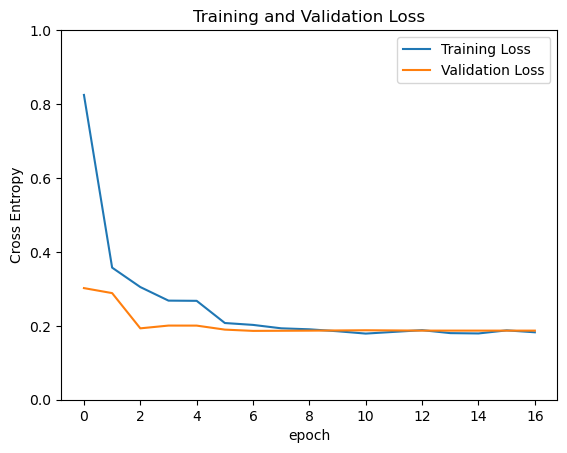

In [32]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



plt.show()

In [33]:
test_dir

'/kaggle/input/new-image/test/test/'

In [34]:
from tensorflow.keras.utils import load_img
import matplotlib.pyplot as pl
from tensorflow.keras.utils import img_to_array

In [38]:
ca = list(os.listdir(test_dir+"malignant"))
non_ca = list(os.listdir(test_dir+"benign"))

In [39]:
predictions = []
labels = []

In [42]:
for name in ca:
    img_path = test_dir+ 'malignant/' + name
    img = load_img(img_path, target_size=(512, 512))
    img_array = img_to_array(img)
    #img_array = img_array/255.
    img_batch = np.expand_dims(img_array, axis=0)   
    predic = model.predict(img_batch)
    if predic < 0.5:
        predictions.append(0)
        labels.append(1)
    else:
        predictions.append(1)
        labels.append(1)
    

1/1 [==============================] - 0s 22ms/step


In [44]:
for name in non_ca:
    img_path = test_dir+ 'benign/' + name
    img = load_img(img_path, target_size=(512, 512))
    img_array = img_to_array(img)
    #img_array = img_array/255.
    img_batch = np.expand_dims(img_array, axis=0)   
    predic = model.predict(img_batch)
    if predic < 0.5:
        predictions.append(0)
        labels.append(0)
    else:
        predictions.append(1)
        labels.append(0)
    

1/1 [==============================] - 0s 22ms/step


In [45]:
len(ca) + len(non_ca)

1865

In [46]:
len(predictions)

1865

In [47]:
len(labels)

1865

[[0.965625   0.034375  ]
 [0.11698113 0.88301887]]


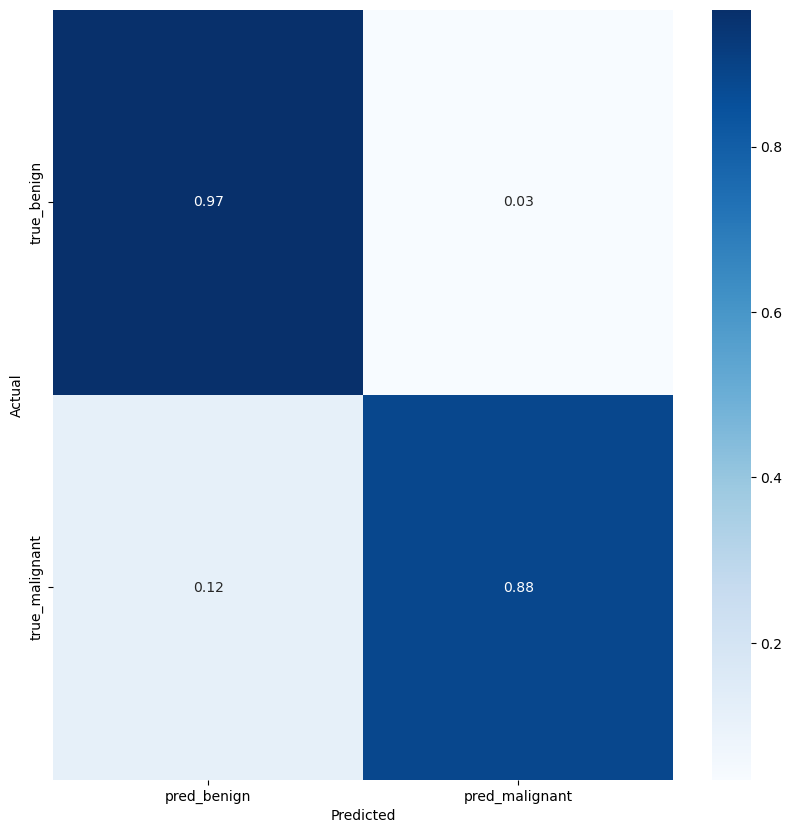

ROC AUC: 0.924


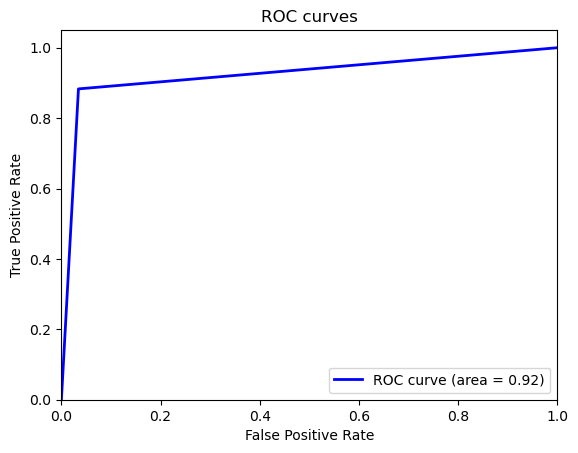

Melanoma Sensitivity: 0.8830188679245283
Melanoma Specificity: 0.965625


In [49]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

def plot_confusion_matrix(y_test, y_pred):
  cmn = confusion_matrix(y_test, y_pred)
  # Normalise
  cmn = cmn.astype('float') / cmn.sum(axis=1)[:, np.newaxis]
  # print it
  print(cmn)
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(cmn, annot=True, fmt='.2f', 
              xticklabels=[f"pred_{c}" for c in class_names], 
              yticklabels=[f"true_{c}" for c in class_names],
              cmap="Blues"
              )
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  # plot the resulting confusion matrix
  plt.show()


def plot_roc_auc(y_true, y_pred):
    """
    This function plots the ROC curves and provides the scores.
    """
    # prepare for figure
    plt.figure()
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    # obtain ROC AUC
    roc_auc = auc(fpr, tpr)
    # print score
    print(f"ROC AUC: {roc_auc:.3f}")
    # plot ROC curve
    plt.plot(fpr, tpr, color="blue", lw=2,
                label='ROC curve (area = {f:.2f})'.format(d=1, f=roc_auc))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves')
    plt.legend(loc="lower right")
    plt.show()

plot_confusion_matrix(labels, predictions)
plot_roc_auc(labels, predictions)
sensitivity = sensitivity_score(labels, predictions)
specificity = specificity_score(labels, predictions)

print("Melanoma Sensitivity:", sensitivity)
print("Melanoma Specificity:", specificity)

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1600
           1       0.81      0.88      0.84       265

    accuracy                           0.95      1865
   macro avg       0.90      0.92      0.91      1865
weighted avg       0.96      0.95      0.95      1865



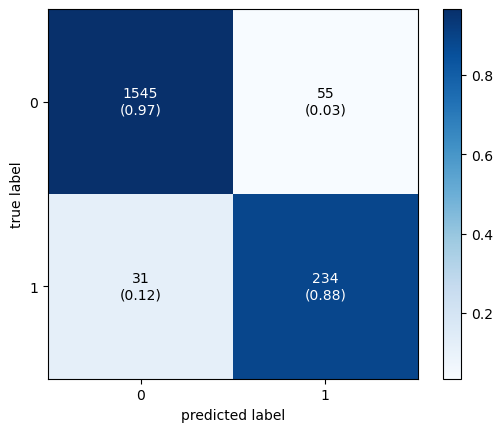

In [50]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
print(classification_report(labels, predictions))
cm1 = confusion_matrix(labels, predictions)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()